--- MOSTRANDO IMAGEN DEL DATASET LIMPIO ---


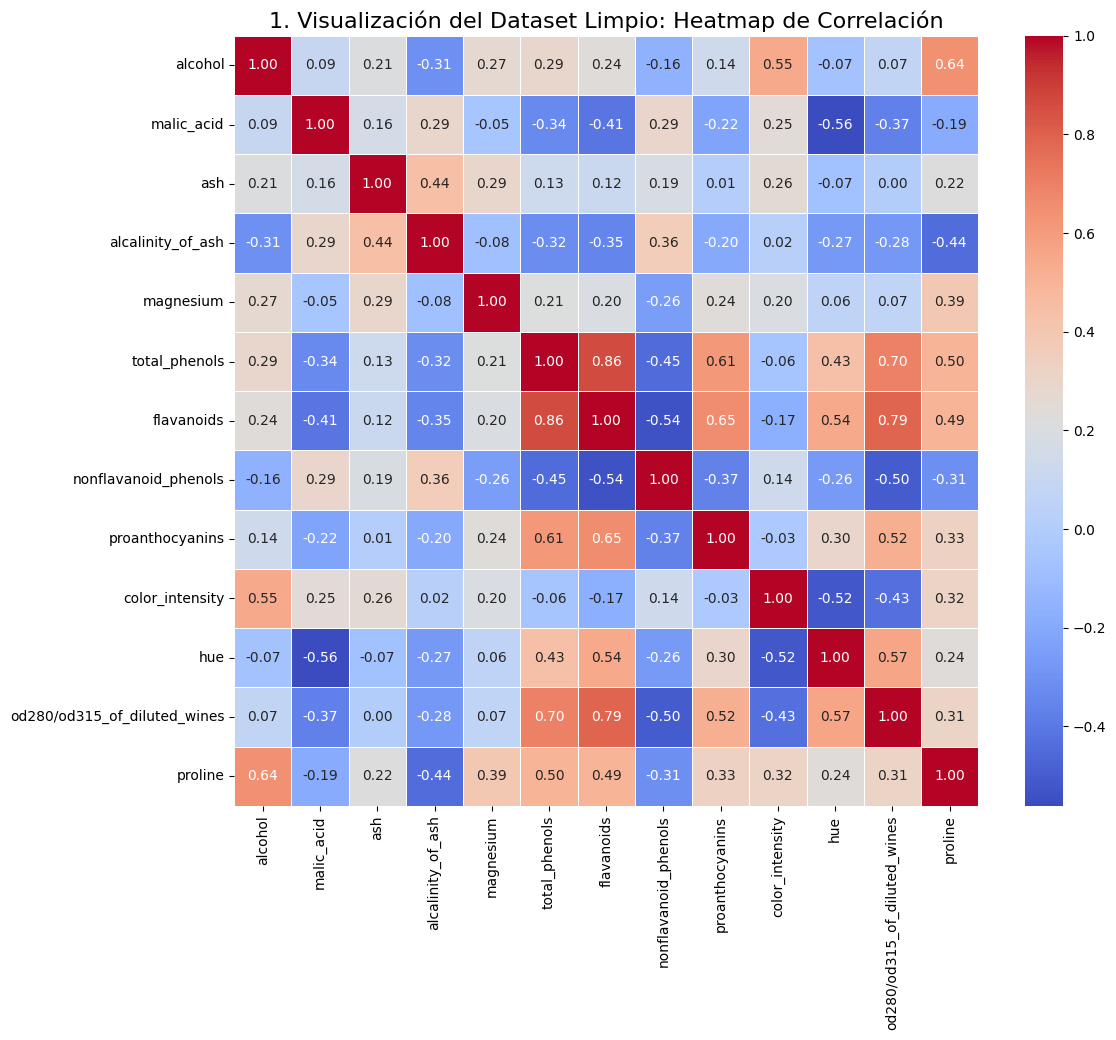



--- MOSTRANDO DISTRIBUCIÓN DEL DATASET ---


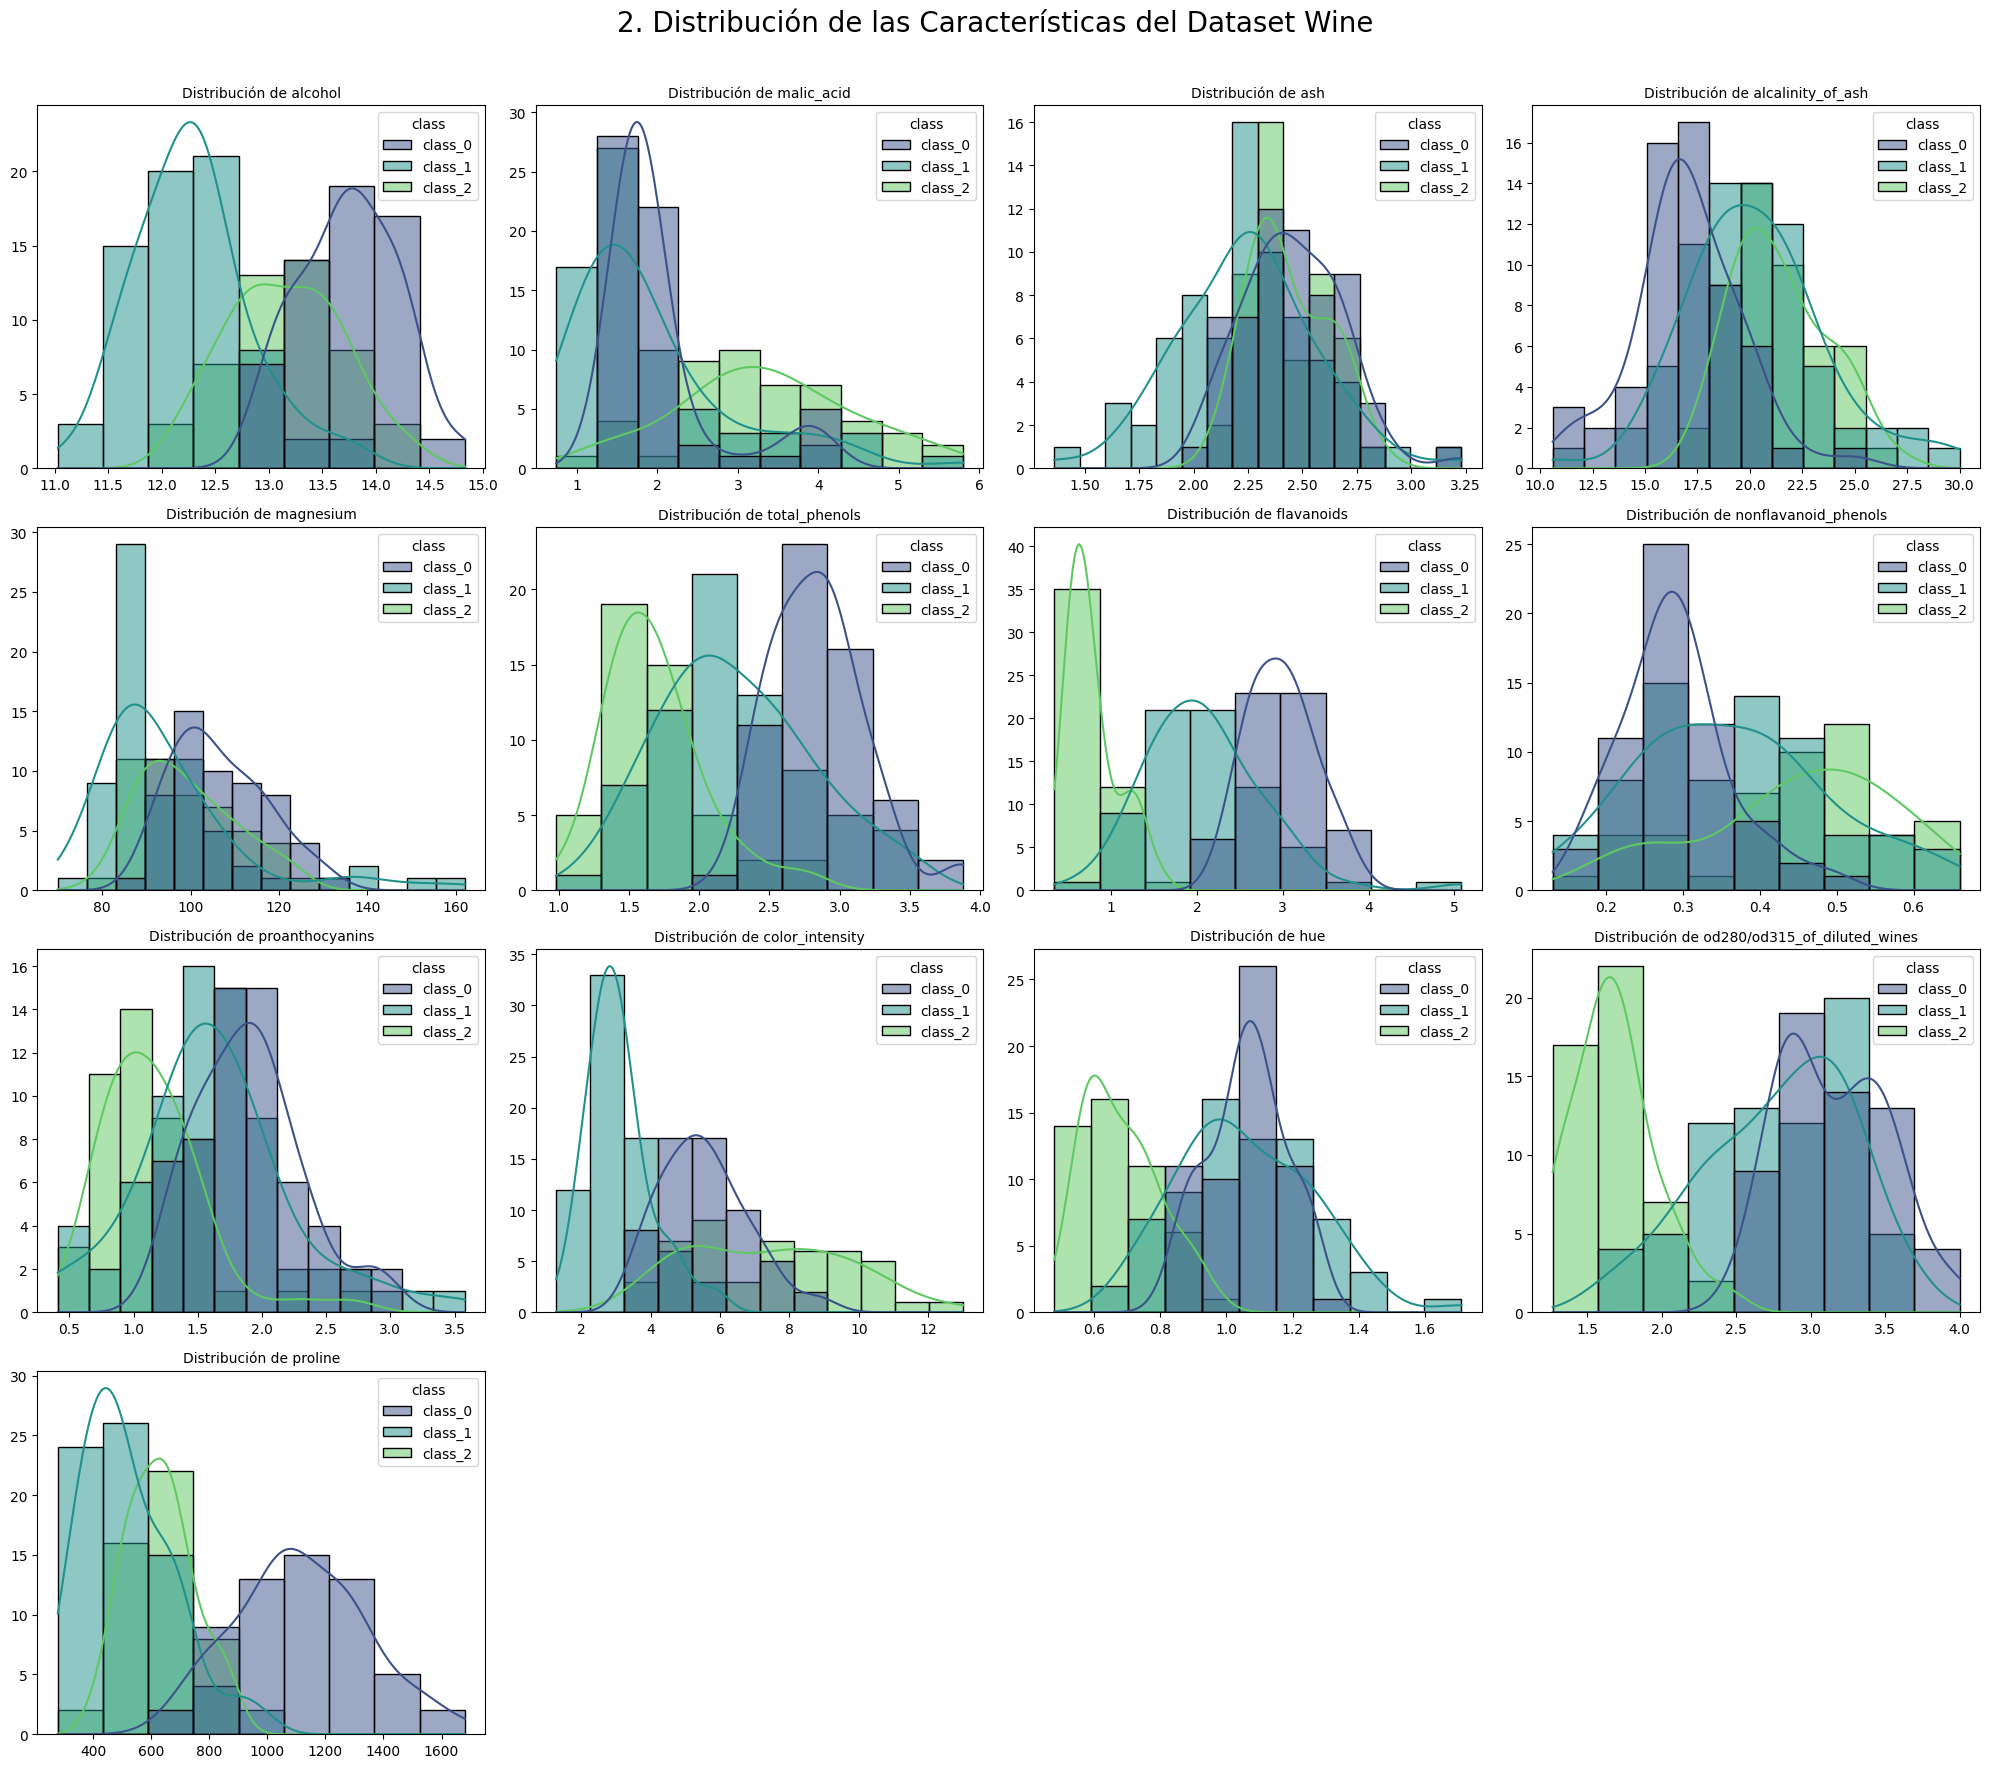



Aplicando PCA...
PCA completado.
Aplicando Gaussian Random Projection...
Gaussian Random Projection completado.
Aplicando t-SNE... (esto puede tardar un momento)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completado.
Aplicando FastICA...
FastICA completado.


--- MOSTRANDO MÉTRICAS DE CADA ALGORITMO ---

## Métricas para PCA:
- Varianza Explicada por Componente: [0.3620, 0.1921]
- Varianza Explicada Acumulada: 0.5541

## Métricas para GaussianRandomProjection:
- Correlación de Distancias (Pearson): 0.6168

## Métricas para TSNE:
- Divergencia KL Final: 0.3763
- Confiabilidad (Trustworthiness): 0.9606

## Métricas para FastICA:
- Error de Reconstrucción (MSE): 0.4459
- Kurtosis de los Componentes: [-1.2418, -0.9837]


--- MOSTRANDO IMAGEN COMPUESTA CON RESULTADOS DE LOS ALGORITMOS ---


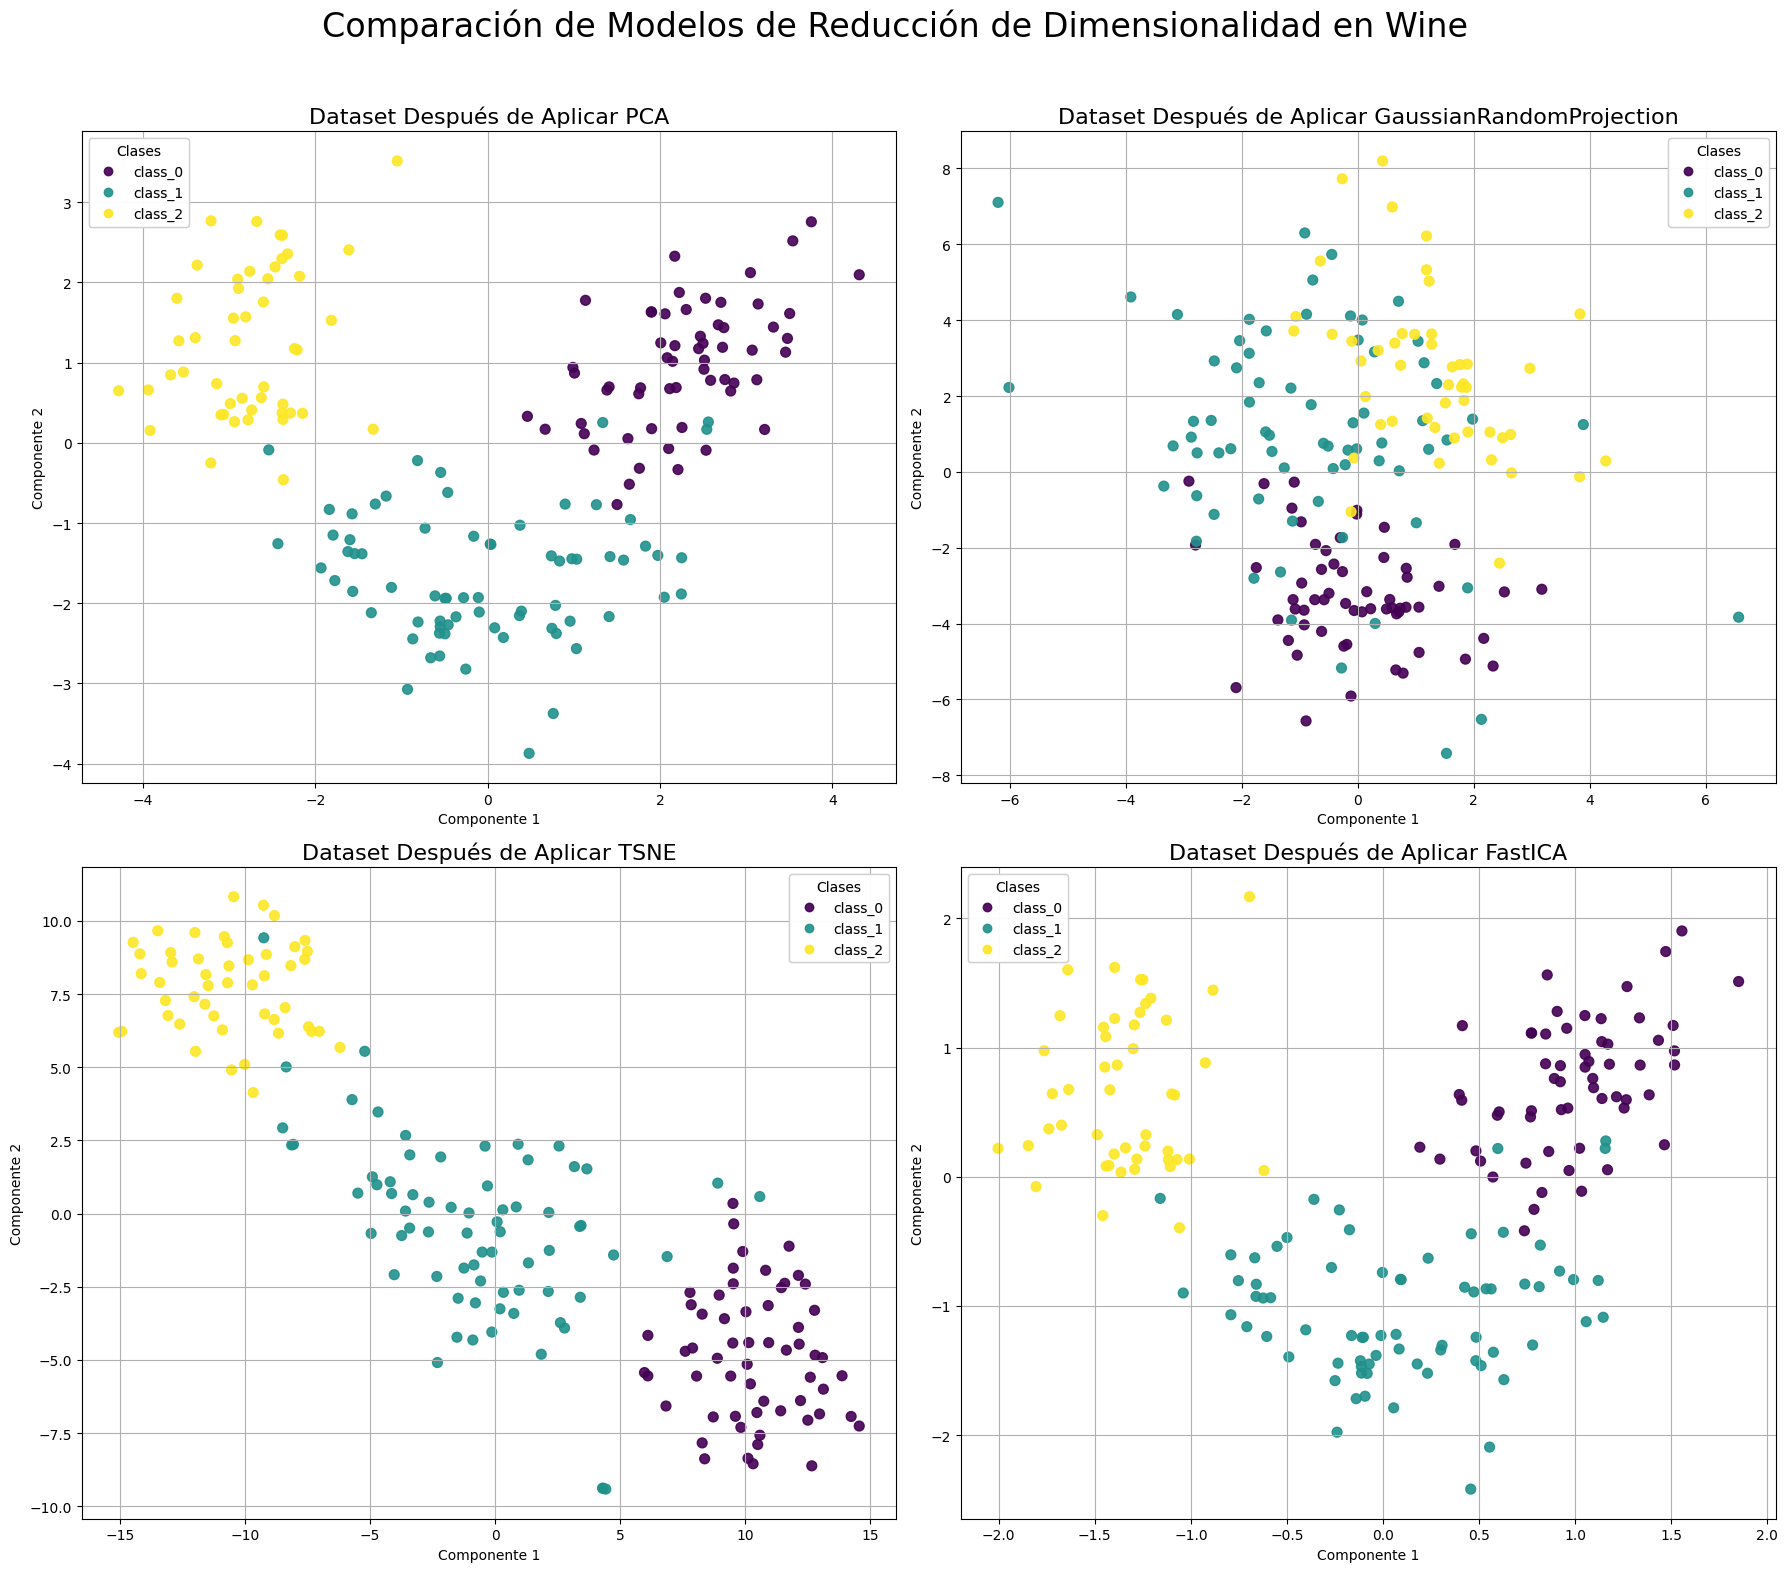

In [2]:
# 1. IMPORTACIÓN DE BIBLIOTECAS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE

# Bibliotecas adicionales para las métricas
from sklearn.metrics import mean_squared_error
from sklearn.manifold import trustworthiness
from scipy.stats import kurtosis, pearsonr
from scipy.spatial.distance import pdist

# --- PASO 1 y 2: CARGAR, VISUALIZAR Y MOSTRAR DISTRIBUCIÓN (Sin cambios) ---

# Cargar el dataset de Wine
wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names

# Crear un DataFrame de pandas
wine_df = pd.DataFrame(X, columns=feature_names)
wine_df['class'] = [target_names[i] for i in y]


# Visualizar el heatmap de correlación
print("--- MOSTRANDO IMAGEN DEL DATASET LIMPIO ---")
plt.figure(figsize=(12, 10))
correlation_matrix = wine_df.drop('class', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("1. Visualización del Dataset Limpio: Heatmap de Correlación", fontsize=16)
plt.show()
print("\n" + "="*50 + "\n")


# Mostrar histogramas
print("--- MOSTRANDO DISTRIBUCIÓN DEL DATASET ---")
fig, axes = plt.subplots(4, 4, figsize=(20, 18))
fig.suptitle('2. Distribución de las Características del Dataset Wine', fontsize=20)
for ax, feature in zip(axes.flatten(), feature_names):
    sns.histplot(data=wine_df, x=feature, hue='class', kde=True, ax=ax, palette='viridis')
    ax.set_title(f'Distribución de {feature}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
for i in range(len(feature_names), len(axes.flatten())):
    axes.flatten()[i].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
print("\n" + "="*50 + "\n")


# --- PASO 3: APLICAR LOS 4 ALGORITMOS DE REDUCCIÓN DE DIMENSIONALIDAD ---

# Escalar los datos es fundamental
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diccionarios para almacenar los resultados y métricas
results = {}
metrics = {}

# a) Aplicar PCA y calcular métricas
print("Aplicando PCA...")
pca = PCA(n_components=2, random_state=42)
results['PCA'] = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
metrics['PCA'] = {
    'Varianza Explicada por Componente': explained_variance,
    'Varianza Explicada Acumulada': np.sum(explained_variance)
}
print("PCA completado.")

# b) Aplicar Gaussian Random Projection y calcular métricas
print("Aplicando Gaussian Random Projection...")
grp = GaussianRandomProjection(n_components=2, random_state=42)
results['GaussianRandomProjection'] = grp.fit_transform(X_scaled)
# Métrica: Preservación de distancias (Correlación de Pearson)
dist_orig = pdist(X_scaled)
dist_proj = pdist(results['GaussianRandomProjection'])
corr, _ = pearsonr(dist_orig, dist_proj)
metrics['GaussianRandomProjection'] = {'Correlación de Distancias (Pearson)': corr}
print("Gaussian Random Projection completado.")

# c) Aplicar t-SNE y calcular métricas
print("Aplicando t-SNE... (esto puede tardar un momento)")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
results['TSNE'] = tsne.fit_transform(X_scaled)
metrics['TSNE'] = {
    'Divergencia KL Final': tsne.kl_divergence_,
    'Confiabilidad (Trustworthiness)': trustworthiness(X_scaled, results['TSNE'], n_neighbors=10)
}
print("t-SNE completado.")

# d) Aplicar FastICA y calcular métricas
print("Aplicando FastICA...")
ica = FastICA(n_components=2, random_state=42, max_iter=1000)
results['FastICA'] = ica.fit_transform(X_scaled)
# Métrica 1: Error de reconstrucción
X_reconstructed = ica.inverse_transform(results['FastICA'])
# Métrica 2: Kurtosis de los componentes
metrics['FastICA'] = {
    'Error de Reconstrucción (MSE)': mean_squared_error(X_scaled, X_reconstructed),
    'Kurtosis de los Componentes': kurtosis(results['FastICA'])
}
print("FastICA completado.")
print("\n" + "="*50 + "\n")


# --- PASO 3.5: MOSTRAR LAS MÉTRICAS CALCULADAS ---
print("--- MOSTRANDO MÉTRICAS DE CADA ALGORITMO ---")

for model_name, metric_values in metrics.items():
    print(f"\n## Métricas para {model_name}:")
    for metric_name, value in metric_values.items():
        if isinstance(value, np.ndarray):
            # Formatear arrays para una mejor lectura
            formatted_value = ", ".join([f"{v:.4f}" for v in value])
            print(f"- {metric_name}: [{formatted_value}]")
        else:
            print(f"- {metric_name}: {value:.4f}")
print("\n" + "="*50 + "\n")


# --- PASO 4: VISUALIZAR EL DATASET COMPUESTO CON LOS ALGORITMOS APLICADOS ---

print("--- MOSTRANDO IMAGEN COMPUESTA CON RESULTADOS DE LOS ALGORITMOS ---")
# Crear una figura con una cuadrícula de 2x2 para los cuatro modelos
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle("Comparación de Modelos de Reducción de Dimensionalidad en Wine", fontsize=24)

# Mapear los nombres de los modelos a sus posiciones en la cuadrícula
model_mapping = {
    'PCA': axes[0, 0],
    'GaussianRandomProjection': axes[0, 1],
    'TSNE': axes[1, 0],
    'FastICA': axes[1, 1]
}

# Generar un gráfico para cada modelo
for model_name, data_transformed in results.items():
    ax = model_mapping[model_name]
    scatter = ax.scatter(data_transformed[:, 0], data_transformed[:, 1], c=y, cmap='viridis', alpha=0.9, s=50)

    ax.set_title(f'Dataset Después de Aplicar {model_name}', fontsize=16)
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.grid(True)

    # Crear leyenda con los nombres de las clases de vino
    legend = ax.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Clases")
    ax.add_artist(legend)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()